In [1]:
from pathlib import Path
import pandas as pd
import re
import numpy as np

from lmfit import Model, Parameter

import matplotlib.pyplot as plt
%matplotlib notebook

from scipy import special

In [2]:
working_input_filename = 'data/fitting_that_works_2.txt'
not_working_input_filename = 'data/fitting_that_does_not_work_2.txt'

assert Path(working_input_filename).exists(), "{} does not exists!".format(working_input_filename)
assert Path(not_working_input_filename).exists(), "{} does not exists!".format(not_working_input_filename)

# load data sets / metadata 

In [3]:
names_col = ['tof', 'cross_section']
skiprows = 11

working_data_set = pd.read_csv(working_input_filename, skiprows=skiprows, names=names_col)
not_working_data_set = pd.read_csv(not_working_input_filename, skiprows=skiprows, names=names_col)

In [4]:
def retrieve_metadata(filename):
    metadata = []
    with open(filename) as f:
        for line in f:
            if line.startswith("#\n"):
                break
            metadata.append(line)
    return metadata

In [5]:
working_metadata = retrieve_metadata(working_input_filename)
not_working_metadata = retrieve_metadata(not_working_input_filename)

In [6]:
working_metadata

['# Bragg peak fitting of row 13\n',
 '# x0: 61\n',
 '# y0: 83\n',
 '# width: 400\n',
 '# height: 400\n',
 '# a0: 1.2896260538091084\n',
 '# b0: -29.308173406243323\n',
 '# ahkl: -0.09137667873512957\n',
 '# bhkl: 5.995053070926488\n']

In [7]:
not_working_metadata

['# Bragg peak fitting of row 14\n',
 '# x0: 62\n',
 '# y0: 84\n',
 '# width: 398\n',
 '# height: 398\n',
 '# a0: 1.2897799307233395\n',
 '# b0: -29.357916417454767\n',
 '# ahkl: -0.09110476614243247\n',
 '# bhkl: 5.941839748824731\n']

# extracting metadata

In [8]:
regular_expression = r'^# (?P<name>.*): (?P<value>.*)\n'

def extract_metadata_value(metadata_array):
    dict_metadata = {}
    for _line in metadata_array[1:]:
        m = re.search(regular_expression, _line)
        if m:
            dict_metadata[m.group('name')] = np.float(m.group('value'))
    return dict_metadata

In [9]:
dict_metadata_working = extract_metadata_value(working_metadata)
dict_metadata_not_working = extract_metadata_value(not_working_metadata)

In [10]:
dict_metadata_working

{'x0': 61.0,
 'y0': 83.0,
 'width': 400.0,
 'height': 400.0,
 'a0': 1.2896260538091084,
 'b0': -29.308173406243323,
 'ahkl': -0.09137667873512957,
 'bhkl': 5.995053070926488}

In [11]:
dict_metadata_not_working

{'x0': 62.0,
 'y0': 84.0,
 'width': 398.0,
 'height': 398.0,
 'a0': 1.2897799307233395,
 'b0': -29.357916417454767,
 'ahkl': -0.09110476614243247,
 'bhkl': 5.941839748824731}

# fitting

In [12]:
def kropff_bragg_peak_tof(tof, a0, b0, ahkl, bhkl, tofhkl, sigma, tau):
	"""Equation 4.3 and 4.4 found in Development and application of Bragg edge neutron transmission
	imaging on the IMAT beamline. Thesis by Ranggi Sahmura Ramadhan. June 2019
	:param
	tof (tof)
	a0 fix parameter
	b0 fix parameter
	ahkl fix parameter
	bhkl fix parameter
	tofhkl parameter to fit
	tau parameter to fit
	sigma parameter to fit
	"""
	def B(tofhkl, sigma, tau, tof):
		const1 = (sigma*sigma) / (2 * tau*tau)
		const2 = sigma / tau

		part1 = special.erfc(-(tof - tofhkl) / (np.sqrt(2) * sigma))
		part2 = np.exp((-(tof - tofhkl) / tau) + const1)
		part3 = special.erfc((-(tof - tofhkl)/(np.sqrt(2) * sigma)) + const2)
		return 0.5 * (part1 - part2 * part3)

	exp_expression_1 = np.exp(-(a0 + b0 * tof))
	exp_expression_2 = np.exp(-(ahkl + bhkl * tof))
	expression_3 = (1 - np.exp(-(ahkl + bhkl * tof)) * B(tofhkl, sigma, tau, tof))

	return exp_expression_1 * (exp_expression_2 + expression_3)


In [13]:
gmodel = Model(kropff_bragg_peak_tof, nan_policy='propagate', independent_vars=['tof'])


In [14]:
def fit(xaxis, yaxis, a0, b0, ahkl, bhkl, tofhkl_init, tau_init, sigma_init):
    yaxis = -np.log(yaxis)
    _result = gmodel.fit(yaxis, tof=xaxis,
                         a0=Parameter('a0', value=a0, vary=False),
                         b0=Parameter('b0', value=b0, vary=False),
                         ahkl=Parameter('ahkl', value=ahkl, vary=False),
                         bhkl=Parameter('bhkl', value=bhkl, vary=False),
                         tofhkl=tofhkl_init,
                         sigma=sigma_init,
                         tau=tau_init)
    
    return _result

In [42]:
a0_w = dict_metadata_working['a0']
b0_w = dict_metadata_working['b0']
ahkl_w = dict_metadata_working['ahkl']
bhkl_w = dict_metadata_working['bhkl']
xaxis_w = np.array(working_data_set['tof'])
yaxis_w = np.array(working_data_set['cross_section'])

a0_nw = dict_metadata_not_working['a0']
b0_nw = dict_metadata_not_working['b0']
ahkl_nw = dict_metadata_not_working['ahkl']
bhkl_nw = dict_metadata_not_working['bhkl']
xaxis_nw = np.array(not_working_data_set['tof'])
yaxis_nw = np.array(not_working_data_set['cross_section'])

tofhkl_init = 1e-6
tau_init = 1
sigma_init = [1e-7, 1e-6, 1e-5]

_result_working_data_set = fit(xaxis_w, yaxis_w, 
                                a0_w, b0_w, 
                                ahkl_w, bhkl_w, 
                                tofhkl_init, tau_init, sigma_init[0])

index_sigma = 0
while (True):
    _result_not_working_data_set = fit(xaxis_nw, yaxis_nw,   # I replaced xaxis_nw by xaxis_w
                                       a0_nw, b0_nw,
                                       ahkl_nw, bhkl_nw,
                                       tofhkl_init, tau_init, 
                                       sigma_init[index_sigma])
    tofhkl_nw = _result_not_working_data_set.params['tofhkl'].value
    if tofhkl_nw > 0:
        break
    index_sigma += 1
    if index_sigma >= len(sigma_init):
        break
                                
tofhkl_w = _result_working_data_set.params['tofhkl'].value
tofhkl_w_error = _result_working_data_set.params['tofhkl'].stderr
sigma_w = _result_working_data_set.params['sigma'].value
sigma_w_error = _result_working_data_set.params['sigma'].stderr
tau_w = _result_working_data_set.params['tau'].value
tau_w_error = _result_working_data_set.params['tau'].stderr

tofhkl_nw = _result_not_working_data_set.params['tofhkl'].value
tofhkl_nw_error = _result_not_working_data_set.params['tofhkl'].stderr
sigma_nw = _result_not_working_data_set.params['sigma'].value
sigma_nw_error = _result_not_working_data_set.params['sigma'].stderr
tau_nw = _result_not_working_data_set.params['tau'].value
tau_nw_error = _result_not_working_data_set.params['tau'].stderr

# Displaying the data

In [43]:
print("Raw Data".center(40, '-'))
raw_data = {'w': yaxis_w,
           'nw': yaxis_nw}
df_data = pd.DataFrame(raw_data)
print(df_data)

print("")
print("initial parameters".center(40, '-'))
meta_data = {'working_set': [a0_w, b0_w, ahkl_w, bhkl_w],
            'not_working_set': [a0_nw, b0_nw, ahkl_nw, bhkl_nw]}
df_w = pd.DataFrame(meta_data)
print(df_w)

print("")
print("fitted parameters".center(40, '-'))
result_data = {'working_set': [tofhkl_w, sigma_w, tau_w],
              'not_working_set': [tofhkl_nw, sigma_nw, tau_nw]}
df_nw = pd.DataFrame(result_data)
print(df_nw)

----------------Raw Data----------------
           w        nw
0   0.699655  0.699586
1   0.702285  0.702246
2   0.704804  0.704776
3   0.706581  0.706567
4   0.706911  0.706851
5   0.708736  0.708679
6   0.709122  0.709012
7   0.709111  0.709051
8   0.710310  0.710256
9   0.709540  0.709449
10  0.708778  0.708691
11  0.709897  0.709774
12  0.710483  0.710398
13  0.710364  0.710301
14  0.710542  0.710485
15  0.710655  0.710568
16  0.710657  0.710555
17  0.710654  0.710603

-----------initial parameters-----------
   working_set  not_working_set
0     1.289626         1.289780
1   -29.308173       -29.357916
2    -0.091377        -0.091105
3     5.995053         5.941840

-----------fitted parameters------------
   working_set  not_working_set
0     0.007095         0.007095
1     0.000021         0.000020
2     0.000037         0.000037


<IPython.core.display.Javascript object>


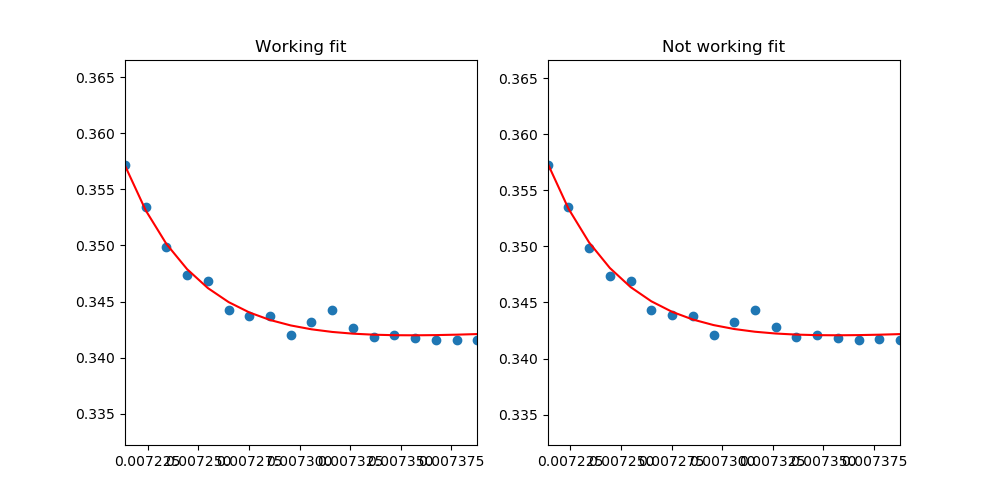

Text(0.5, 1.0, 'Not working fit')

In [44]:
working_fit = kropff_bragg_peak_tof(xaxis_w, a0_w, b0_w, ahkl_w, bhkl_w, tofhkl_w, sigma_w, tau_w)
not_working_fit = kropff_bragg_peak_tof(xaxis_nw, a0_nw, b0_nw, ahkl_nw, bhkl_nw, tofhkl_nw, sigma_w, tau_nw)

fig, ax = plt.subplots(ncols=2, figsize=(10,5), num="fits")

ax[0].scatter(xaxis_w, -np.log(yaxis_w))
ax[0].plot(xaxis_w, working_fit, '-r')
ax[0].set_xlim(np.min(xaxis_w), np.max(xaxis_w))
ax[0].set_title("Working fit")

ax[1].scatter(xaxis_nw, -np.log(yaxis_nw))
ax[1].plot(xaxis_w, not_working_fit, '-r')
ax[1].set_xlim(np.min(xaxis_nw), np.max(xaxis_nw))
ax[1].set_title("Not working fit")